# Solving "Day61" problem with matrix pencil method

W.M.Saj 2020

## Problem

Cassie Kozyrkov _"When not to use machine learning or AI"_ 

_For those who like a challenge, why don’t you try see if your favorite machine learning algorithm can find the pattern and turn it into a useful recipe? Let me know what you think the answer for Day 61 is._

https://towardsdatascience.com/when-not-to-use-machine-learning-or-ai-8185650f6a29

![problem](https://miro.medium.com/max/1400/1*HyQQoVpZnfmjp_TzBaaN9g.png)

## Data

In [1]:
import pandas as pd
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt

In [2]:
raw_data = [(1,28),  (2,17),  (3,92),  (4,41),  (5,9),   (6,87),  (7,54), (8,3),   (9,78),  (10,67), (11,1),  (12,67), (13,78), (14,3), (15,55), (16,86), (17,8),  (18,42), (19,92), (20,17), (21,29), (22,94), (23,28), (24,18), (25,93), (26,40), (27,9),  (28,87), (29,53), (30,3),  (31,79), (32,66), (33,1),  (34,68), (35,77), (36,3),  (37,56), (38,86), (39,8),  (40,43), (41,92), (42,16), (43,30), (44,94), (45,27), (46,19), (47,93), (48,39), (49,10), (50,88), (51,53), (52,4),  (53,80), (54,65), (55,1),  (56,69), (57,77), (58,3),  (59,57), (60,86),]

In [3]:
df = pd.DataFrame({'day':[x[0] for x in raw_data] , 'dose':[x[1] for x in raw_data]})

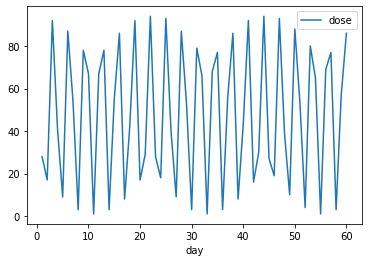

In [4]:
df.plot(x='day',y='dose')

Looks like harmonic signal , so just use harmonic analysis ?

## Matrix pencil method

To decompose 'signal' (doses) to harmonic components: 
https://en.wikipedia.org/wiki/Generalized_pencil-of-function_method

Implementation below for real signals is based less or more on other codes:
* https://github.com/WMSaj13/EMFIDES/blob/master/matlab/matrix%20pencil%20method/matrixpencil.m
* https://github.com/pstjohn/decay-methods/blob/master/methods/sinusoid_estimation.py


In [5]:
def  matrix_pencil_method(signal, sing_cut_off = 3,sing_cut_off2 = 2):
    """
    matrix pencil method implementation for real signals 
    for given signal finds that  real angular frequencies and decay factor so :
        signal(t) ~ sum of (unknown_amplitude * exp(-decay*t) * sin(freqeuncy *t + unknown_phase)) 
    """
  
    # preconditions
    assert not np.any(np.iscomplex(signal)),'this works for real signals'
    signal = signal.astype('float')
    
    
    N = len(signal)
    L = int(N/3)
    X = scipy.linalg.hankel(signal[:N-L], signal[N-L-1:])
    U, S, V = scipy.linalg.svd(X[:,1:L+1], full_matrices=False)
    
    # cut off according to singular values
    M=0
    for indx in range(1,L):
        M=indx
        if np.log10(np.abs(S[indx]/S[0]))<-1*sing_cut_off: 
            break
        if np.log10(np.abs(S[indx]/S[indx-1]))<-1*sing_cut_off2: 
            break
            
    print('singular: {} cut off at {}'.format(S,M))
    
    V = V.T
    P = np.diag(1./S[:M]).dot((U[:,:M].T.dot(X[:,:L])).dot(V[:,:M]))
    p = np.log(scipy.linalg.eigvals(P))
    
    # real signals case
    indx = np.imag(p)>=0
    frequencies = np.imag(p[indx])
    decays = np.real(p[indx])

    return frequencies, decays

In [6]:
def estimate_amplitudes_and_phases(signal, frequencies, decays):
    """
    estimate with least squares method amplitues and phases of 
    given signal, real angular frequencies and decay factors , so :
        signal(t) = sum of (amplitude * exp(-decay*t) * sin(freqency *t + phase)) 
    """
    # preconditions
    assert not np.any(np.iscomplex(signal)),'this works for real signals'
    signal = signal.astype('float')
    
    n = np.arange(len(signal)).reshape((1,len(signal)))
        
    # split propagating and pure decay factors to improve matrix conditionality
    prop_indx = frequencies!=0
    decay_indx = np.logical_not(prop_indx)
    
    k = frequncies.shape[0]
    k_prop = np.sum(prop_indx)
    k_decay = k - k_prop
    
    frequencies_prop =frequencies[prop_indx][..., np.newaxis]
    decays_prop = decays[prop_indx][..., np.newaxis]
    decays_decay = decays[decay_indx][..., np.newaxis]
    
    M = np.vstack([
        np.exp((1j*(frequencies_prop + 1j*decays_prop)).dot(n)),
        np.exp(-decays_decay.dot(n)),
        np.exp((-1j*(frequencies_prop - 1j*decays_prop)).dot(n))
        ]).T
       
    # solve lstsq
    complex_amplitudes,residuals,rank,s = np.linalg.lstsq(M, signal,rcond=None)
    print('lstsq residuals {} rank {} singular {}'.format(residuals,rank,s))
    
    # reorder, convert to output
    prop_indx = prop_indx.flatten()
    decay_indx = decay_indx.flatten()

    amplitudes = np.zeros_like(complex_amplitudes[:k],dtype=np.float)
    phases = np.zeros_like(complex_amplitudes[:k],dtype=np.float)
    
    amplitudes[prop_indx] = 2*np.abs(complex_amplitudes[:k-k_decay])
    phases[prop_indx] = np.angle(complex_amplitudes[:k-k_decay])
     
    amplitudes[decay_indx] = np.abs(complex_amplitudes[k-k_decay:k])
    phases[decay_indx] = np.angle(complex_amplitudes[k-k_decay:k])   
        
    return amplitudes, phases

In [7]:
def reconstruct_signal(x,amplitudes,decays,frequencies,phases):
    """
    returns signal for given x
    """
    signal = 0
    for i in range(len(frequencies)):
        signal+= amplitudes[i]*np.exp(-decays[i]*x)*np.cos(frequencies[i]*x+phases[i])
    return signal

## The harmonic components of data

In [8]:
frequncies,decays =  matrix_pencil_method(df.dose,sing_cut_off=5)
amplitudes,phases = estimate_amplitudes_and_phases(df.dose,frequncies,decays)

singular: [1.35289320e+03 6.70933981e+02 6.39278917e+02 2.25340582e+00
 2.18026304e+00 2.02919842e+00 1.95505360e+00 1.93316846e+00
 1.88306901e+00 1.86305018e+00 1.69588399e+00 1.48367968e+00
 1.45063448e+00 1.35245381e+00 1.27973196e+00 1.18285282e+00
 1.12446175e+00 1.10506167e+00 1.02828376e+00 9.64125253e-01] cut off at 3
lstsq residuals [3.75844718] rank 3 singular [7.82241986 7.75331533 7.71409017]


In [9]:
print('harmonics:')
print('amplitude',amplitudes)
print('frequencies',frequncies)
print('decay',decays)
print('phase',phases)

harmonics:
amplitude [47.54191908 46.41810587]
frequencies [0.         2.00007452]
decay [-1.42818854e-04 -4.27076559e-05]
phase [-1.12092036e-16  1.99816536e+00]


Let's check how it reproduces the data

## Reconstruct signal from harmonic components

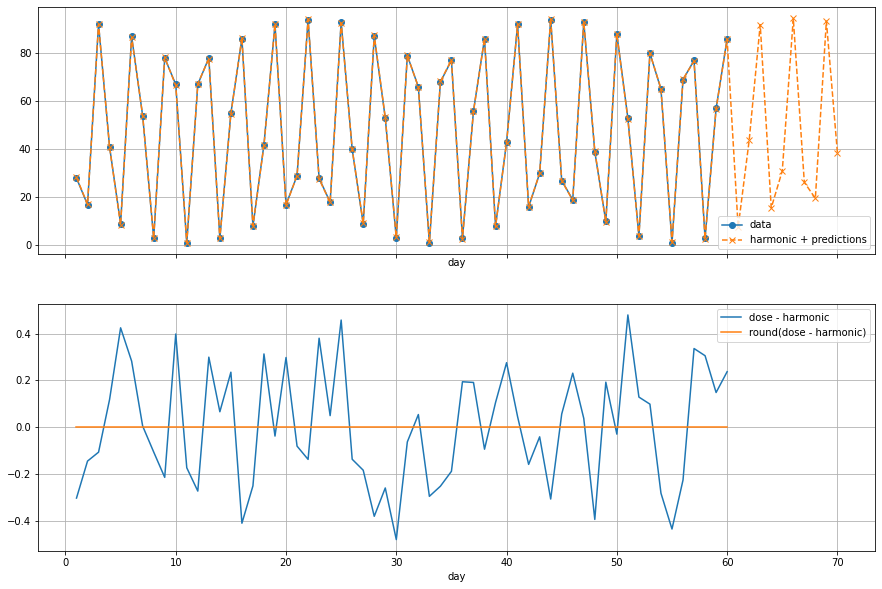

In [10]:
dose_rec = reconstruct_signal(np.arange(len(df.dose)),amplitudes,decays,frequncies,phases)
dose_rec_pred = reconstruct_signal(np.arange(len(df.dose)+10),amplitudes,decays,frequncies,phases)

fig,ax = plt.subplots(2,1,figsize=(15,10),sharex=True)
                 

ax[0].plot(df.day,df.dose,'o-',label = 'data')
ax[0].plot(range(1,len(df.dose)+11),dose_rec_pred,'x--',label = 'harmonic + predictions')
ax[0].set_xlabel('day')
ax[0].grid()
ax[0].legend()

x = range(1,len(df.dose)+1)
ax[1].plot(x,df.dose-dose_rec,label='dose - harmonic')
ax[1].plot(x,df.dose-np.round(dose_rec),label='round(dose - harmonic)')
ax[1].set_xlabel('day')
ax[1].grid()
ax[1].legend()
plt.show()

Seems that the rounded value of the harmonic composition fits well the value of dose in data

## Prediction for day 61

In [11]:
# pred at next point ("day 61")
dose_pred = np.round(reconstruct_signal(len(df.dose),amplitudes,decays,frequncies,phases))
print("dose at day 61 prediction : {} mg".format(dose_pred))    

dose at day 61 prediction : 8.0 mg
